# 1. Training an Unsupervised Generative Adversarial Network (GAN)

**Objective**

  - Train an unsupervised GAN to generate images of handwritten digits.



**Workflow**

  - Implement a variation of a DCGAN (Deep Convolutional GAN) that is trained on the MNIST set to generate images of handwritten digits.

  -One may find that keeping track of the loss does not provide as good of an indicator of how much progress model is making. When it comes to training GANs, it is not uncommon to get good results even though training technically does not converge. It is therefore advantageous to either save or display the outputs generated from some constant input vector every few epochs.



## 1.1 Simple GAN - MNIST digits generator

Important imports.

In [ ]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

from keras.datasets import mnist
from keras.layers import Dense, Flatten, Reshape
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Sequential
from keras.optimizers import Adam
from keras.engine.saving import load_model
from IPython.display import Math, HTML

Dimensions of MNIST dataset images.

In [ ]:
img_rows = 28
img_cols = 28
channels = 1

img_shape = (img_rows, img_cols, channels)

z_dim = 100

### 1.1.1 Implementing the Generator

In [ ]:
def build_generator(img_shape, z_dim):
    model = Sequential()

    model.add(Dense(128, input_dim=z_dim))

    model.add(LeakyReLU(alpha=0.01))

    model.add(Dense(28 * 28 * 1, activation='tanh'))

    model.add(Reshape(img_shape))

    return model

### 1.1.2 Implementing the Discriminator

In [ ]:
def build_discriminator(img_shape):

    model = Sequential()

    model.add(Flatten(input_shape=img_shape))

    model.add(Dense(128))

    model.add(LeakyReLU(alpha=0.01))

    model.add(Dense(1, activation='sigmoid'))

    return model



### 1.1.3 Building the model and training loop

In [ ]:
def build_gan(generator, discriminator):

    model = Sequential()

    model.add(generator)
    model.add(discriminator)

    return model


discriminator = build_discriminator(img_shape)
discriminator.compile(loss='binary_crossentropy',
                      optimizer=Adam(),
                      metrics=['accuracy'])

generator = build_generator(img_shape, z_dim)

discriminator.trainable = False

gan = build_gan(generator, discriminator)
gan.compile(loss='binary_crossentropy', optimizer=Adam())



In [ ]:
losses = []
accuracies = []
iteration_checkpoints = []

def train(iterations, batch_size, sample_interval):

    (X_train, _), (_, _) = mnist.load_data()

    X_train = X_train / 127.5 - 1.0
    X_train = np.expand_dims(X_train, axis=3)

    real = np.ones((batch_size, 1))

    fake = np.zeros((batch_size, 1))

    for iteration in range(iterations):



        idx = np.random.randint(0, X_train.shape[0], batch_size)
        imgs = X_train[idx]

        z = np.random.normal(0, 1, (batch_size, 100))
        gen_imgs = generator.predict(z)

        d_loss_real = discriminator.train_on_batch(imgs, real)
        d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
        d_loss, accuracy = 0.5 * np.add(d_loss_real, d_loss_fake)



        z = np.random.normal(0, 1, (batch_size, 100))
        gen_imgs = generator.predict(z)

        g_loss = gan.train_on_batch(z, real)

        if (iteration + 1) % sample_interval == 0:

            losses.append((d_loss, g_loss))
            accuracies.append(100.0 * accuracy)
            iteration_checkpoints.append(iteration + 1)

            print("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" %
                  (iteration + 1, d_loss, 100.0 * accuracy, g_loss))

            sample_images(generator)

In [ ]:
def sample_images(generator, image_grid_rows=4, image_grid_columns=4):

    z = np.random.normal(0, 1, (image_grid_rows * image_grid_columns, z_dim))

    gen_imgs = generator.predict(z)

    gen_imgs = 0.5 * gen_imgs + 0.5

    fig, axs = plt.subplots(image_grid_rows,
                            image_grid_columns,
                            figsize=(4, 4),
                            sharey=True,
                            sharex=True)

    cnt = 0
    for i in range(image_grid_rows):
        for j in range(image_grid_columns):
            axs[i, j].imshow(gen_imgs[cnt, :, :, 0], cmap='gray')
            axs[i, j].axis('off')
            cnt += 1



### 1.1.4 Training the model

1000 [D loss: 0.149261, acc.: 94.53%] [G loss: 3.455479]
2000 [D loss: 0.011821, acc.: 100.00%] [G loss: 7.946626]
3000 [D loss: 0.072686, acc.: 97.27%] [G loss: 5.353356]
4000 [D loss: 0.062197, acc.: 98.05%] [G loss: 6.254305]
5000 [D loss: 0.220370, acc.: 92.58%] [G loss: 4.121236]
6000 [D loss: 0.102646, acc.: 97.27%] [G loss: 4.620561]
7000 [D loss: 0.332141, acc.: 85.94%] [G loss: 3.994438]
8000 [D loss: 0.223059, acc.: 90.23%] [G loss: 3.648339]
9000 [D loss: 0.242343, acc.: 89.84%] [G loss: 4.226812]
10000 [D loss: 0.441521, acc.: 80.86%] [G loss: 2.969228]
11000 [D loss: 0.363843, acc.: 85.55%] [G loss: 3.628828]
12000 [D loss: 0.458120, acc.: 79.69%] [G loss: 2.428975]
13000 [D loss: 0.377443, acc.: 83.98%] [G loss: 3.213623]
14000 [D loss: 0.386045, acc.: 83.98%] [G loss: 3.196204]
15000 [D loss: 0.315381, acc.: 85.94%] [G loss: 3.003650]
16000 [D loss: 0.451216, acc.: 82.03%] [G loss: 2.069764]
17000 [D loss: 0.321494, acc.: 88.28%] [G loss: 2.813737]
18000 [D loss: 0.33887

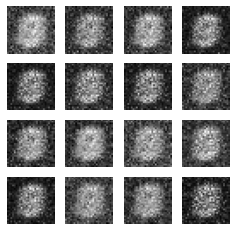

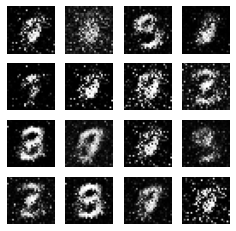

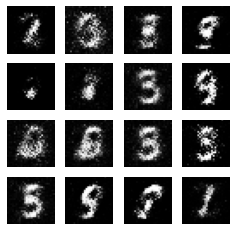

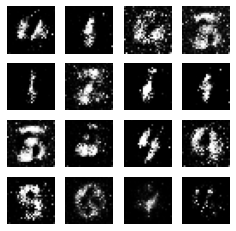

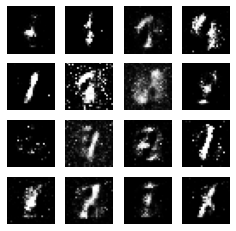

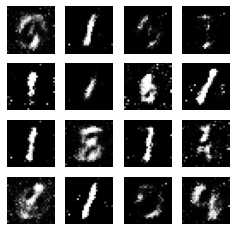

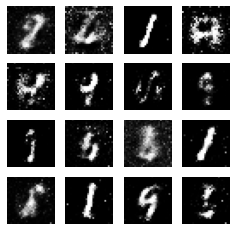

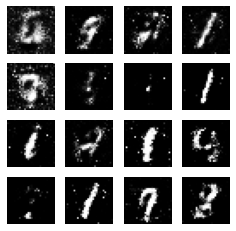

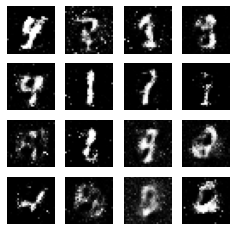

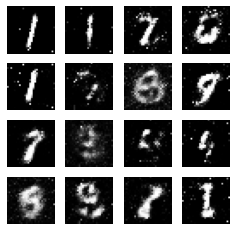

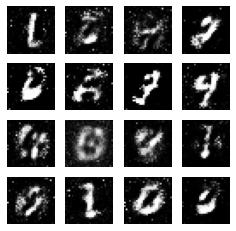

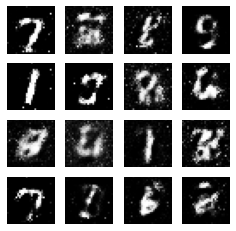

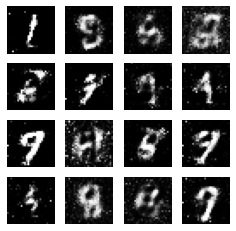

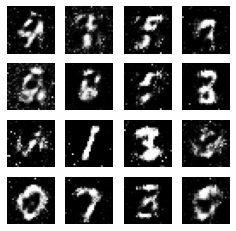

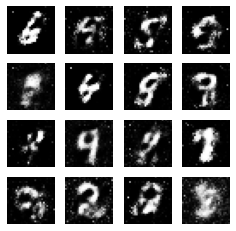

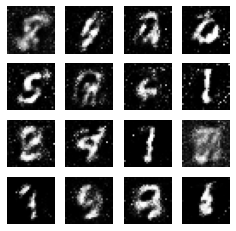

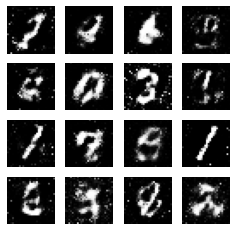

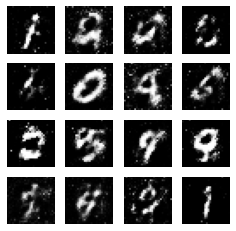

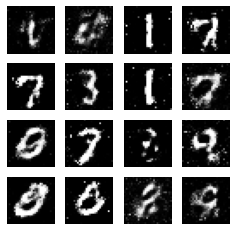

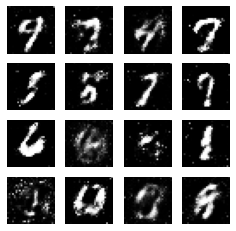

In [ ]:
iterations = 20000
batch_size = 128
sample_interval = 1000

train(iterations, batch_size, sample_interval)

As can be seen on above image most of generated digits are blurry but readable. This simple approach, however, can not fulfill strict medical reqirements and more complicated, convolutional GANs must be used.

# 2. Convolutional neural networks usage with GANs

## 2.1 Batch normalization

Let $\mu_B$ be the mean of the mini-batch B, and $\sigma_{B}^2$ be the variance (mean squared deviation) of the mini-batch B. The normalized value is computed as shown in equation:

In [ ]:
display(HTML("<script src='https://cdnjs.cloudflare.com/ajax/libs/mathjax/2.7.3/"
               "latest.js?config=default'></script>"))

Math(r'\hat{x} = \frac{x - \mu_B}{\sqrt{\sigma^2 + \epsilon}}')

<IPython.core.display.Math object>

The term $\epsilon$ (epsilon) is added for numerical stability, primarily to avoid division by zero. It is set to a small positive constant value, such as 0.001.

In batch normalization, one do not use these normalized values directly. Instead multiply them by γ (gamma) and add β (beta) before passing them as inputs to the next layer; see equation:

In [ ]:
display(HTML("<script src='https://cdnjs.cloudflare.com/ajax/libs/mathjax/2.7.3/"
               "latest.js?config=default'></script>"))

Math(r'y = \gamma\hat{x} + \beta')

<IPython.core.display.Math object>

Importantly, the terms γ and β are trainable parameters, which—just like weights and biases—are tuned during network training. The reason for this is that it may be beneficial for the intermediate input values to be standardized around a mean other than 0 and have a variance other 
than 1. Because γ and β are trainable, the network can learn what values work best.

## 2.2 Generating handwritten digits with DCGAN

In [ ]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
from torchvision import datasets, transforms
from torch import nn
from keras.datasets import mnist
from keras.layers import (
    Activation, BatchNormalization, Dense, Dropout, Flatten, Reshape)
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.models import Sequential
from keras.optimizers import Adam

In [ ]:
img_rows = 28
img_cols = 28
channels = 1

img_shape = (img_rows, img_cols, channels)

z_dim = 100

torch.manual_seed(42)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Now we no longer need a test set, as this is a fully generative unsupervised problem
train_set = torchvision.datasets.MNIST('../data', train=True, download=True, transform=transforms.ToTensor())
train_loader = torch.utils.data.DataLoader(train_set, batch_size=256, shuffle=True, num_workers=10)

# Number of channels in the training images. For color images this is 3
nc = 1

# Size of z latent vector (i.e. size of generator input)
nz = 20

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# Learning rate for optimizers
lr = 0.001

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

## 2.2.1 Implementing the Generator

ConvNets have traditionally been used for image classification tasks, in which the network takes in an image with the dimensions height × width × number of color channels as input and—through a series of convolutional layers—outputs a single vector of class scores, with the dimensions 1 × n, where n is the number of class labels. ConvNet architecture reverse the process: instead of taking an image and processing it into a vector it takes a vector and up-size it to an image.



Putting all the steps together, algorithm is:


In [ ]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz, ngf * 4, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 4 x 4
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 8 x 8
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 16 x 16
            nn.ConvTranspose2d( ngf, nc, 2, 2, 2, bias=False),
            #nn.Tanh()
            nn.Sigmoid()
            # state size. (ngf) x 28 x 28
        )

    def forward(self, input):
        return self.main(input)

## 2.2.2 Implementing the Discriminator

The Discriminator is a ConvNet of the familiar kind, one that takes in an image and outputs a prediction vector: in this case, a binary classification indicating whether the input image was deemed to be real rather than fake.

Putting all the steps together, we do the following:

In [ ]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            # input is (nc) x 28 x 28
            nn.Conv2d(nc, ndf, 2, 2, 2, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 16 x 16
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 8 x 8
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 4 x 4
            nn.Conv2d(ndf * 4, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

## Training the GAN

In [ ]:
# Create the generator
netG = Generator().to(device)
# Apply the weights_init function to randomly initialize all weights
# to mean=0, stdev=0.2.
netG.apply(weights_init)
    
# Create the Discriminator
netD = Discriminator().to(device)

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netD.apply(weights_init)

# Initialize BCELoss function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1
fake_label = 0

# Setup Adam optimizers for both G and D
optimizerD = torch.optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = torch.optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

Epoch  0


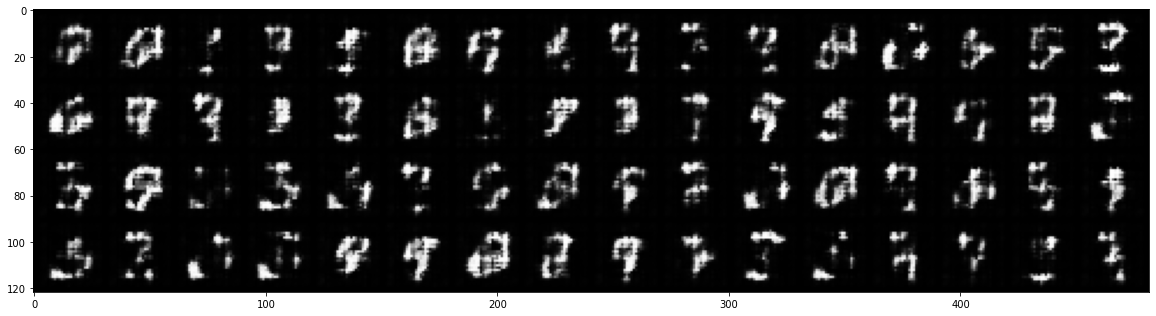

Epoch  1


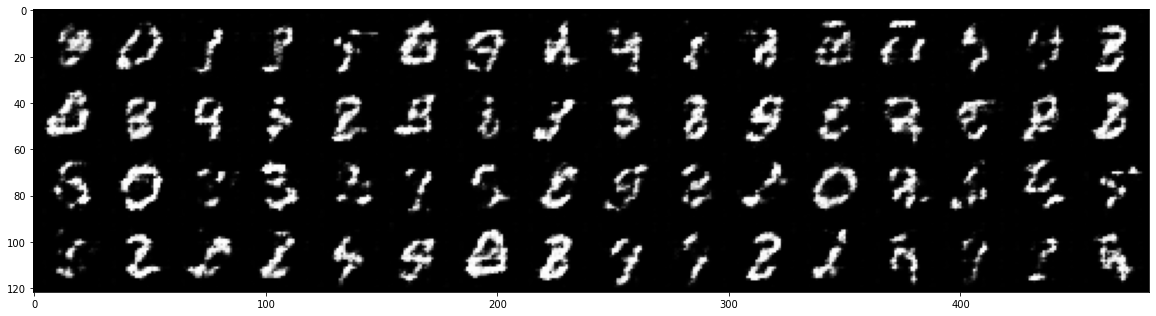

Epoch  2


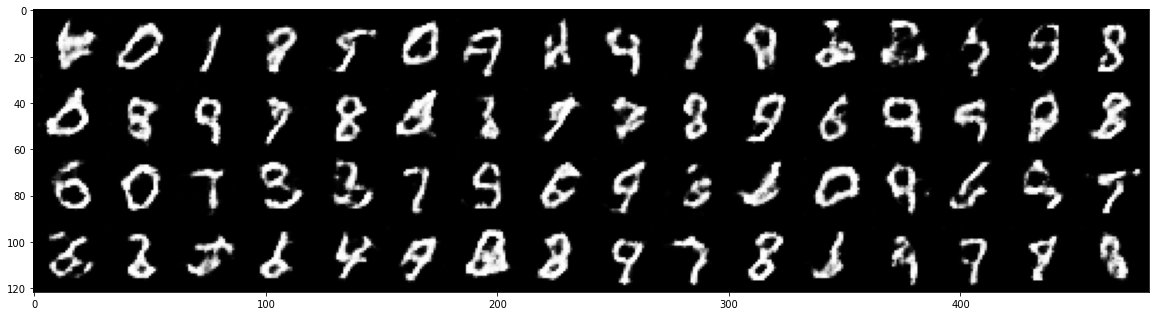

Epoch  3


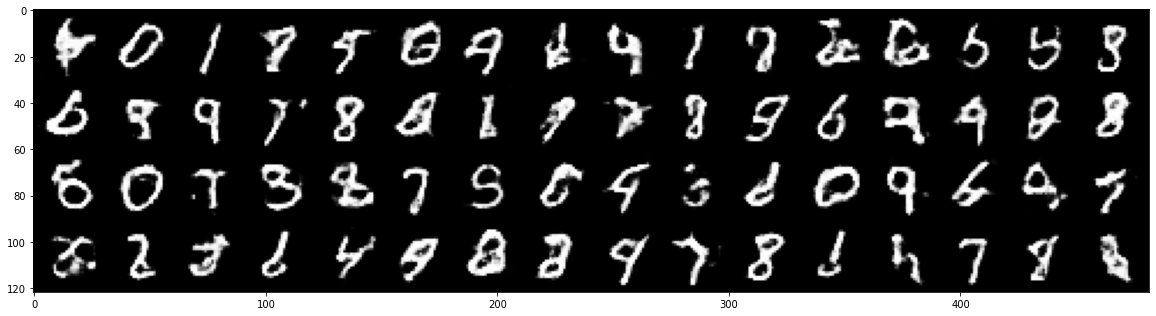

Epoch  4


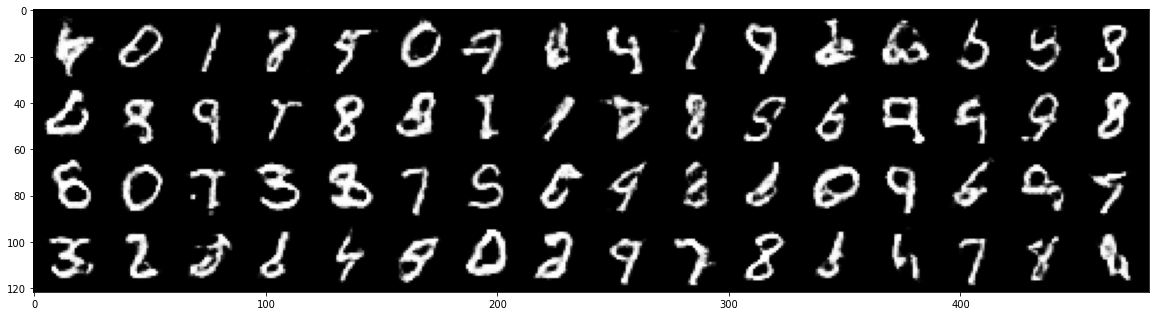

Epoch  5


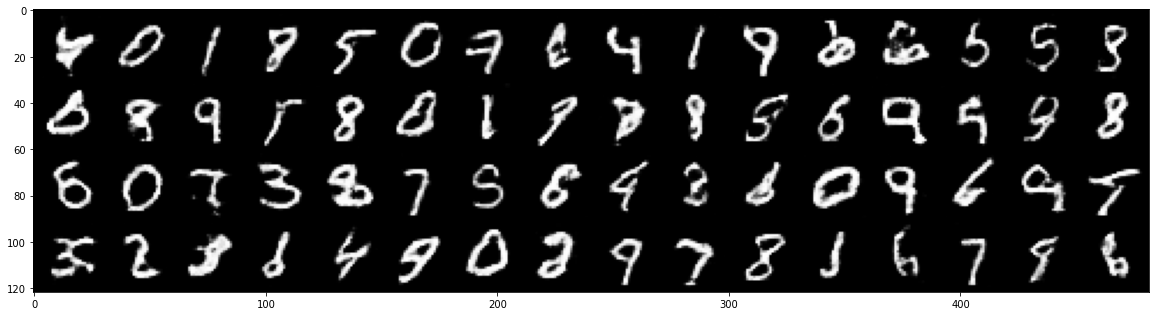

Epoch  6


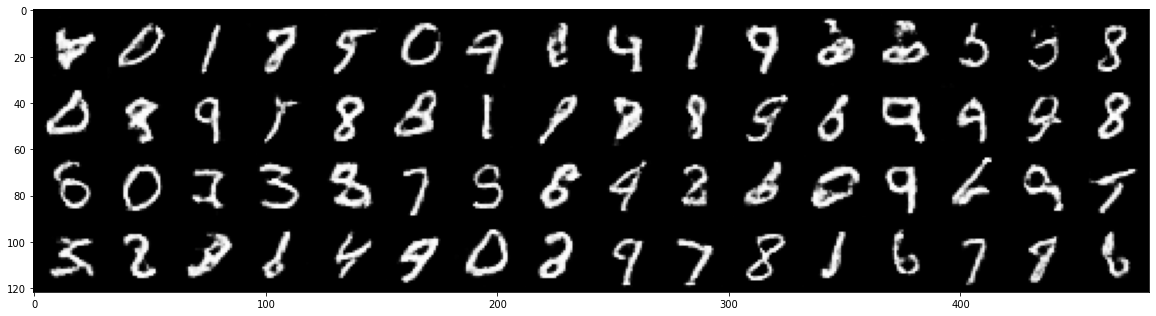

Epoch  7


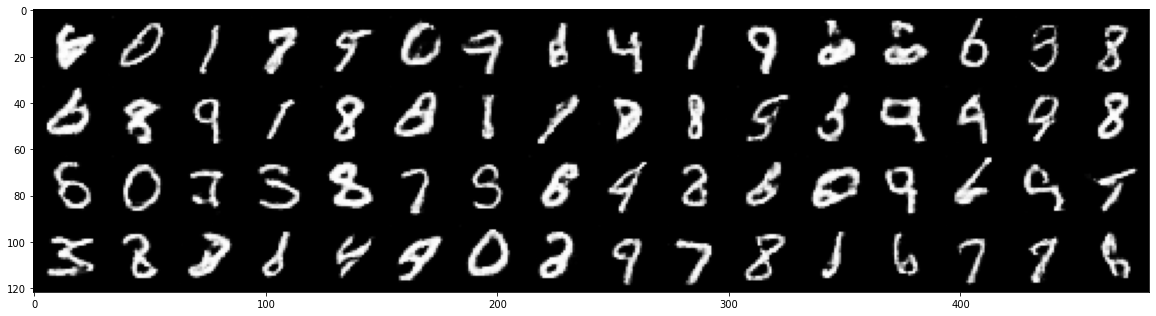

Epoch  8


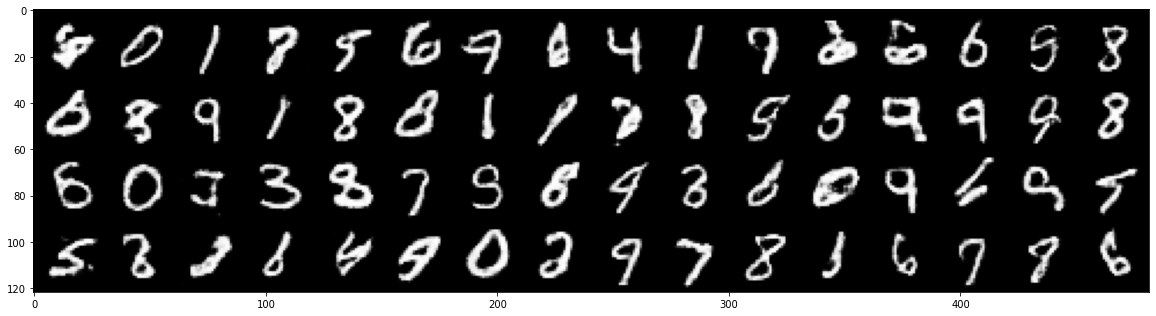

Epoch  9


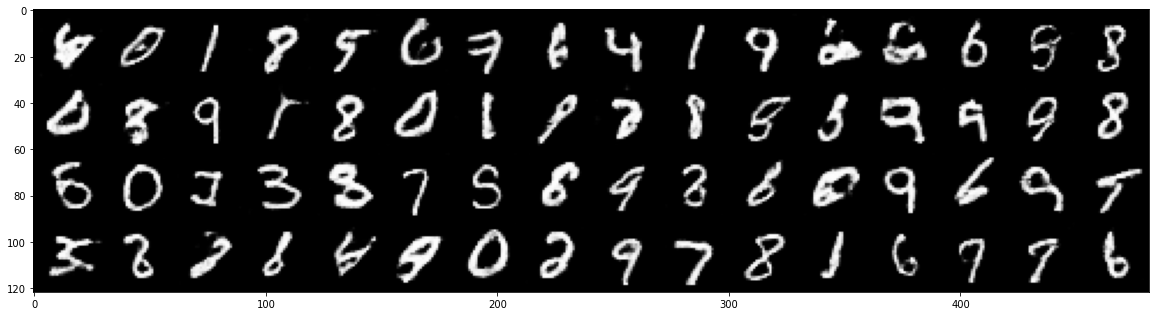

Epoch  10


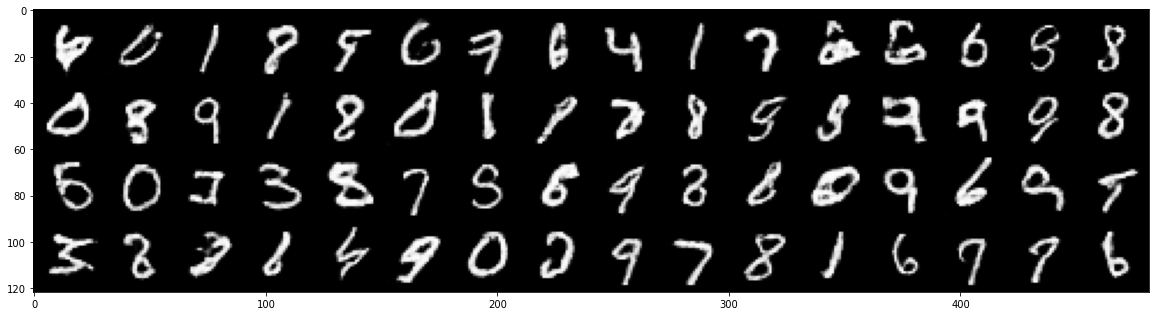

Epoch  11


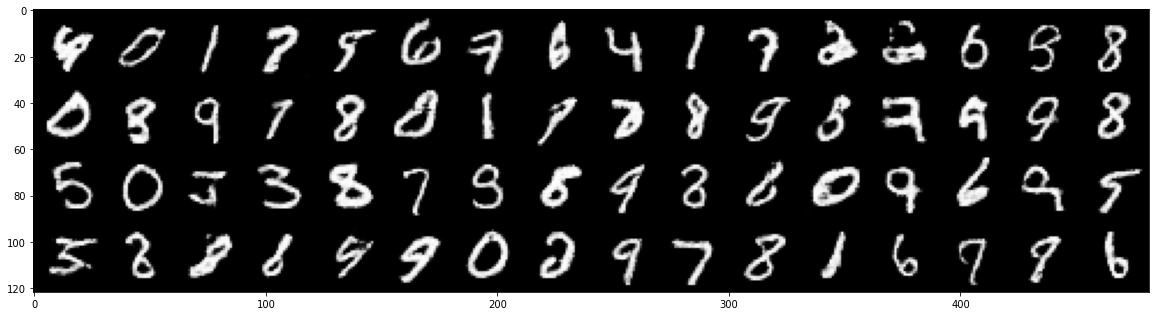

Epoch  12


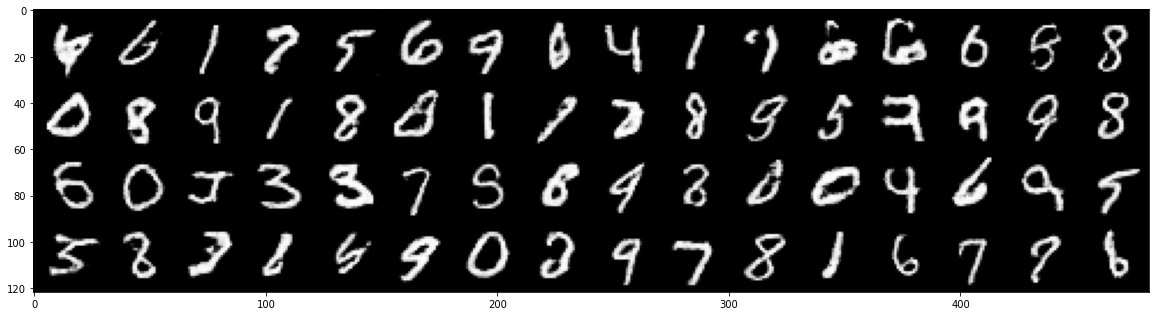

Epoch  13


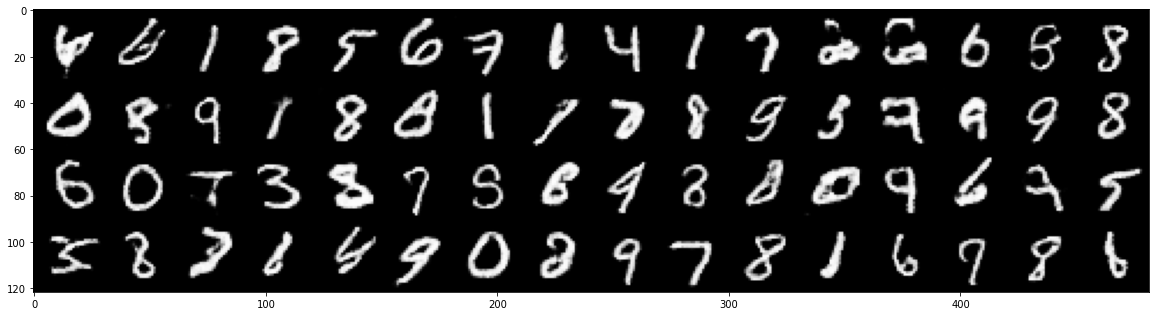

Epoch  14


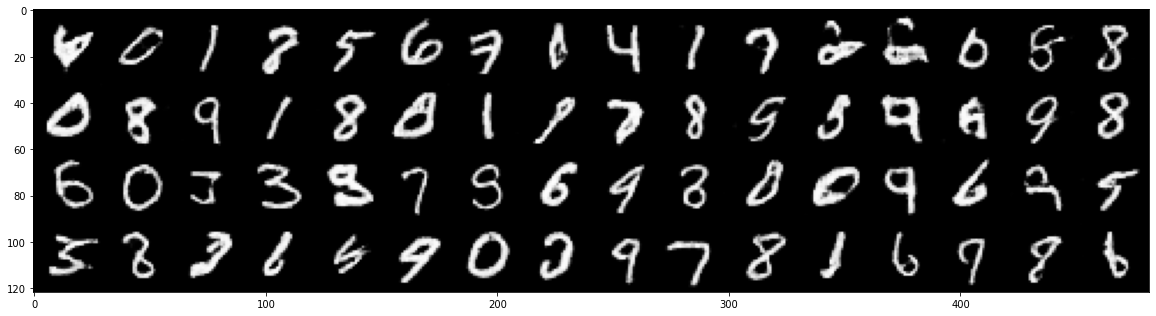

Epoch  15


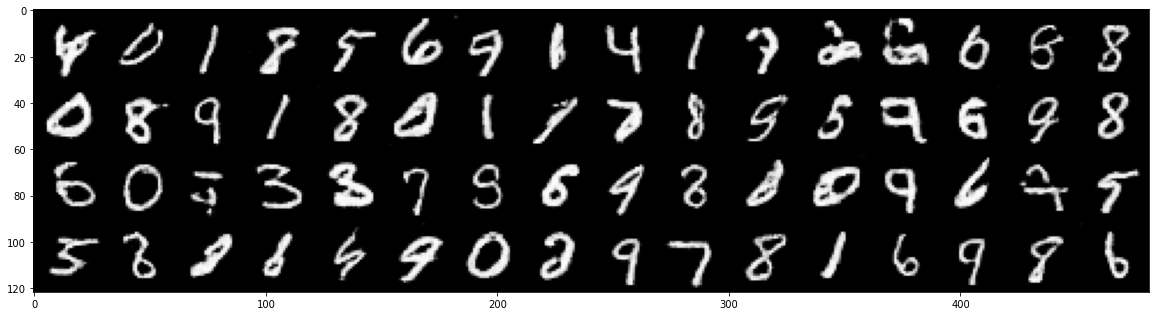

Epoch  16


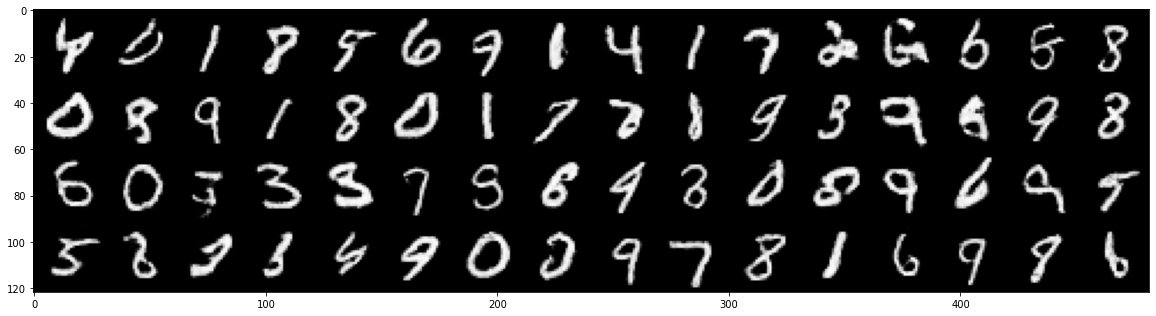

Epoch  17


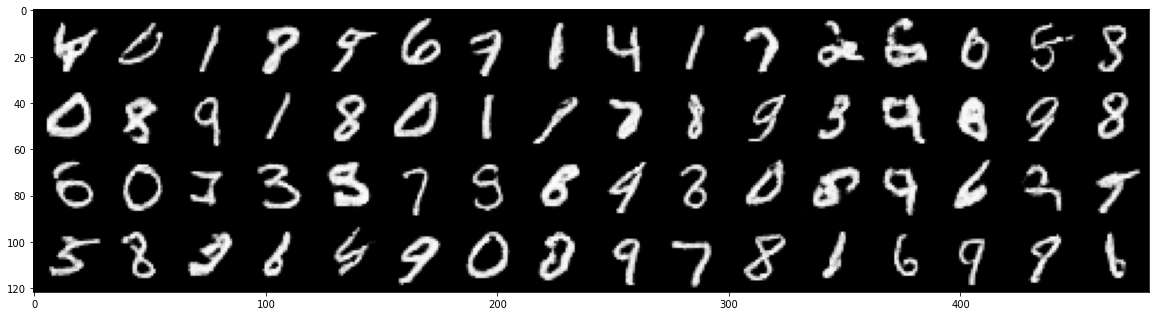

Epoch  18


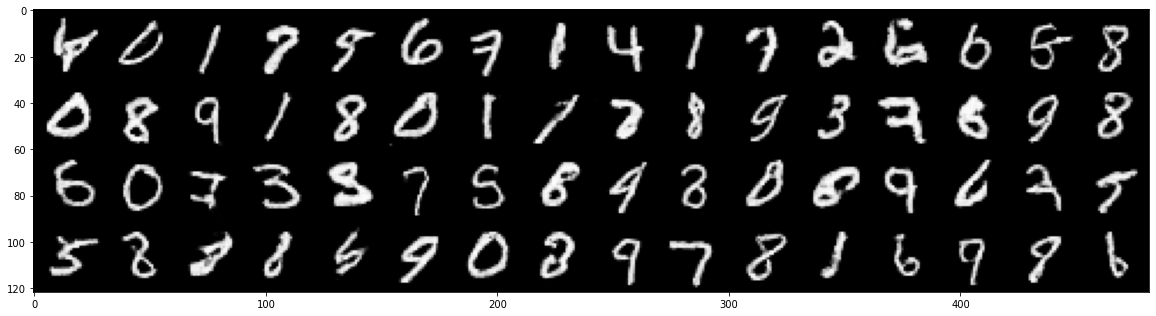

Epoch  19


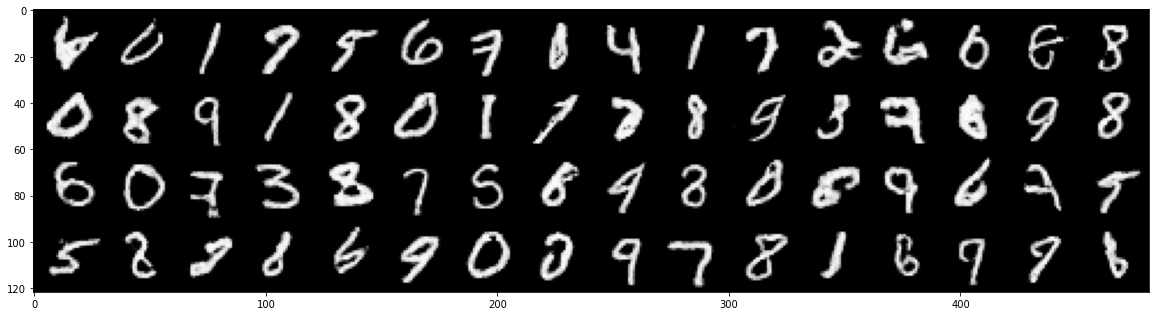

In [ ]:
# Training Loop
for epoch in range(19):
    # For each batch in the dataloader
    for i, data in enumerate(train_loader, 0):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype = torch.float32, device=device)
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Add the gradients from the all-real and all-fake batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()


    with torch.no_grad():
        generated = netG(fixed_noise).detach().cpu()
        image_grid = torchvision.utils.make_grid(generated, nrow=16)
        
        print("Epoch ", epoch)
        plt.figure(figsize=(20,10))
        plt.imshow(image_grid.permute(1, 2, 0))
        plt.pause(0.05)